In [1]:
from configobj import ConfigObj
import numpy as np
import os
import matplotlib.pyplot as plt
import pylab as plot
from scipy.interpolate import CubicSpline
from scipy.interpolate import RegularGridInterpolator
import pyccl as ccl
import scipy
from matplotlib.pyplot import cm
#from HiCOLA import Frontend

## Get expansion and force files

# Run Backend

## Get Power Spectra

In [ ]:
# from paper
"""
wr = 0.0#4.28e-5
wc = 0.11933
wb = 0.02242
h = 0.6766

# We assume:
A_s = 2.1e-9
n_s = 0.966
"""

In [2]:
f_phi_array = np.logspace(-4,0,9)

print(f_phi_array)

[1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00]


In [3]:
# Create cola folders - only need to do this once

# CAREFUL!! might not need this next step
#command = 'cd; rm -r /home/c2042999/HiCOLA_env/Cubic_galileon_emu/Output_backend/COLA_seeds'
#os.system(command)
os.system("cd; cd /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/; mkdir COLA_fphi_tests")


mkdir: cannot create directory ‘COLA_fphi_tests’: File exists


256

In [3]:
## Power spectrum from CCL - backscaling

Pk_ccl = np.zeros(500)

# from paper
wr = 0.0#4.28e-5
wc = 0.11933
wb = 0.02242
h = 0.6766

wm = wc + wb
# We assume:
As = 2.1e-9
ns = 0.966

kk_ccl = np.logspace(-3,1,len(Pk_ccl))*h               # in 1/Mpc
cosmoLCDM = ccl.Cosmology(Omega_c=(wm - wb)/h**2,
                               Omega_b=wb/h**2, 
                               A_s=As, 
                               h = h,
                               n_s=ns,
                               Omega_k=0)

# Omega_g::: Note that if a non-None value is given, this may result in a physically 
# inconsistent model because the CMB temperature will still be non-zero in the parameters.
cosmoLCDM_norad = ccl.Cosmology(Omega_c=(wm - wb)/h**2,
                               Omega_b=wb/h**2, 
                               A_s=As, 
                               h = h,
                               n_s=ns,
                               Omega_k=0,
                               Omega_g = 0,
                               T_CMB = 0.0)

Pk_0 = ccl.power.linear_matter_power(cosmoLCDM, kk_ccl, 1)    # in (Mpc)^3

Growth_0 = ccl.background.growth_factor(cosmoLCDM_norad, 1)

Growth_49 = ccl.background.growth_factor(cosmoLCDM_norad, 1/(1+49))

Pk_ccl = (Growth_49/Growth_0)**2 * Pk_0*h**3    # in (Mpc)^3/h^3

kk_ccl = kk_ccl/h    # in h/Mpc
## Save power spectrum for initial conditions (Linear)
np.savetxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/P_k_z/Pk_lin_z49_LCDM_backscaled_f_phi_tests.dat", np.array([kk_ccl, Pk_ccl]).T)


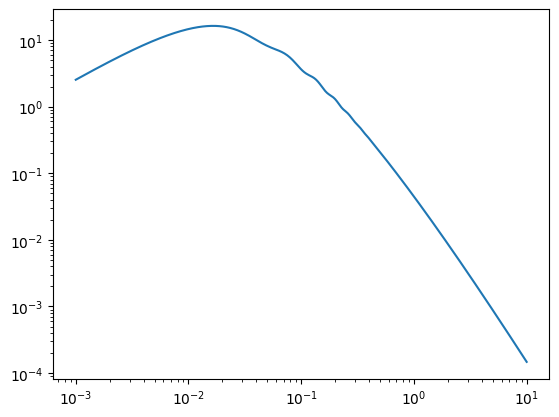

In [4]:
## Plot power spectra (at z = 49, expect very different from z=0)

plt.plot(kk_ccl,Pk_ccl)

plt.xscale("log")
plt.yscale("log")

## Get expansion and force files

In [5]:
"""Define tracker functions"""

# If we are on the tracker, we will get the following constraints equations

# For today formalism 
def k_1T(Omg_m, Omg_r, f_phi):
    return 6*f_phi*(Omg_m + Omg_r - 1)

# dS formalism

def E_dS(Omg_m, Omg_r, f_phi):

    return np.sqrt((1-f_phi)*(1-Omg_m-Omg_r)/2 + np.sqrt(
        ((1-f_phi)*(1-Omg_m-Omg_r)/2)**2 + f_phi*(1-Omg_m-Omg_r)
    ))

In [6]:
''' Define useful functions'''

def hypercube_arrays(f_phi):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi)
    returns two arrays, one for numerical and one for horndeski array
    # numerical - [h , wr , wb , wc, n_s , A_s]
    # horndeski - [f_phi, H0, k_1, g_31]
    """
    wr = 0.0*np.ones(len(f_phi))#4.28e-5
    wc = 0.11933*np.ones(len(f_phi))
    wb = 0.02242*np.ones(len(f_phi))
    h = 0.6766*np.ones(len(f_phi))
    
    # We assume:
    A_s = 2.1e-9*np.ones(len(f_phi))
    n_s = 0.966*np.ones(len(f_phi))

    arr_num = [h, wr, wb, wc, n_s, A_s]
    
    return arr_num

def Update_ini(run, f_phi, arr_num, horn_ini, num_ini):
    """
    Updates files num_ini and horn_ini to include the parameters (numerical and MG) from 
    f_phi and
    arr_num = h , wr , wb , wc, n_s , A_s
    """
    ## Horndeski params
    h , wr , wb , wc, n_s , A_s = arr_num
    config_h = ConfigObj(horn_ini)
    
    k1_track = k_1T((wc + wb)/h**2, wr/h**2, f_phi)

    keys_h = config_h.keys()
    
    config_h[keys_h[1]] = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/f_phi_tests'
    config_h[keys_h[0]] = 'horndeski_model'
    
    config_h[keys_h[2]] = 'k_1*X'
    config_h[keys_h[3]] = 'g_31*X'
    config_h[keys_h[4]] = '0.5'

    config_h[keys_h[7]] = str(k1_track)
    config_h[keys_h[8]] = str("1")
    config_h[keys_h[9]] = str(f_phi)
    config_h[keys_h[10]] = str("1")
    config_h[keys_h[11]] = str("1")
    config_h[keys_h[20]] = str("False")
    config_h[keys_h[22]] = str("1")
    
    ## Numerical params
    config_n = ConfigObj(num_ini)
    keys_n = config_n.keys()
    
    config_n[keys_n[0]] = 'run_'+str(run)

    
    config_n[keys_n[6]] = str(h)
    config_n[keys_n[7]] = str(wr)
    config_n[keys_n[8]] = str(wb)
    config_n[keys_n[9]] = str(wc)
    config_h.filename = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini'
    config_n.filename = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'
    config_h.write(); config_n.write()

In [10]:
"""!!!!! CAREFUL WHEN RUNNING THIS deletes a whole directory of frontend parameter files"""
### Run frontend for all different .ini files

#command = 'cd; rm -r /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/'
#os.system(command)
#command = 'cd /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/; mkdir Output'
#os.system(command)

a_n = hypercube_arrays(f_phi_array)
for i in range(len(f_phi_array)):
    Update_ini(str(i), f_phi_array[i], np.array(a_n).T[i], '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_parameters.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_parameters.ini')
    command = 'cd ; cd /home/c2042999/HiCOLA_env/Hi-COLA; python3 -m HiCOLA.Frontend.generate_simulation_input /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'
    os.system(command)
    

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0004142151350726962, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.30964144154550644
Omega_r0 = 0.0
Omega_lambda0 = 0.6902895225986482
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.00013807171169089028
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/f_phi_tests


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0013098632681440147, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.30964144154550644
Omega_r0 = 0.0
Omega_lambda0 = 0.6901402479098029
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.00043662108938136157
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/f_phi_tests


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0041421513507269615, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.30964144154550644
Omega_r0 = 0.0
Omega_lambda0 = 0.6896681998960391
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.0013807171169090138
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/f_phi_tests


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.013098632681440146, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.30964144154550644
Omega_r0 = 0.0
Omega_lambda0 = 0.6881754530075869
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.004366210893813283
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/f_phi_tests


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.041421513507269615, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.30964144154550644
Omega_r0 = 0.0
Omega_lambda0 = 0.6834549728699486
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.013807171169089916
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/f_phi_tests


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.13098632681440148, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.30964144154550644
Omega_r0 = 0.0
Omega_lambda0 = 0.6685275039854267
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.043662108938133715
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/f_phi_tests


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.4142151350726962, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.30964144154550644
Omega_r0 = 0.0
Omega_lambda0 = 0.6213227026090442
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.13807171169089894
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/f_phi_tests


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-1.3098632681440148, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.30964144154550644
Omega_r0 = 0.0
Omega_lambda0 = 0.4720480137638244
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.4366210893813388
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/f_phi_tests


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-4.142151350726961, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.30964144154550644
Omega_r0 = 0.0
Omega_lambda0 = 0.0
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.3807171169089885
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/f_phi_tests


### Plot background

Text(0, 0.5, '$E^{CuGal}/E^{\\Lambda CDM}$')

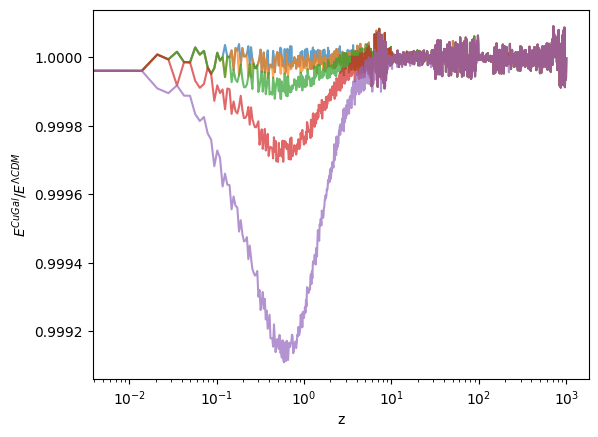

In [13]:
## Plotting ##

fig, axs = plt.subplots(1)

zero_vals = []

for i in range(len(f_phi_array)-4):
    expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/f_phi_tests/horndeski_model_run_{}_expansion.txt".format(i))

    a_today = expansion_today.T[0]
    E_a_today = expansion_today.T[1]
    E_a_GR = np.sqrt((wb+wc)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wb+wc) -wr))/h
    if (np.min(E_a_today/E_a_GR)) == 0.0:
        zero_vals.append(i)
    plt.plot(1/a_today -1, E_a_today/E_a_GR, alpha=0.7)
plt.xscale("log")

#plt.ylim(0.91,1.05)
plt.xlabel("z")
plt.ylabel(r"$E^{CuGal}/E^{\Lambda CDM}$")


Text(0, 0.5, "$-E'$")

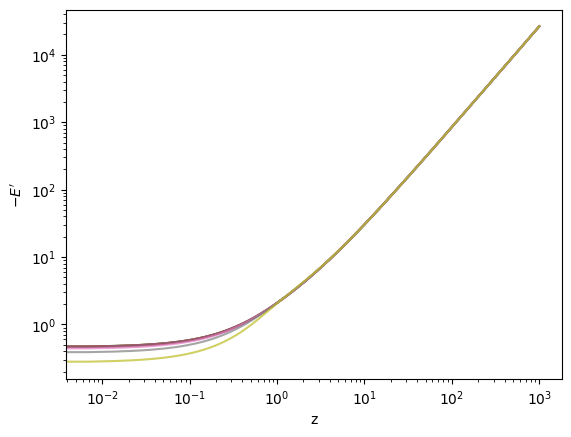

In [74]:
## Plotting ##

fig, axs = plt.subplots(1)


for i in range(len(f_phi_array)):
    expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/f_phi_tests/horndeski_model_run_{}_expansion.txt".format(i))

    a_today = expansion_today.T[0]
    E_a_today = expansion_today.T[1]

    E_prime_a_today = expansion_today.T[2]
    
    plt.plot(1/a_today -1, -E_prime_a_today*E_a_today, alpha=0.7)

plt.xscale("log")


plt.yscale("log")
plt.xlabel("z")
plt.ylabel(r"$-E'$")


Text(0, 0.5, '$chiD^{CuGal}/chiD^{\\Lambda CDM}$')

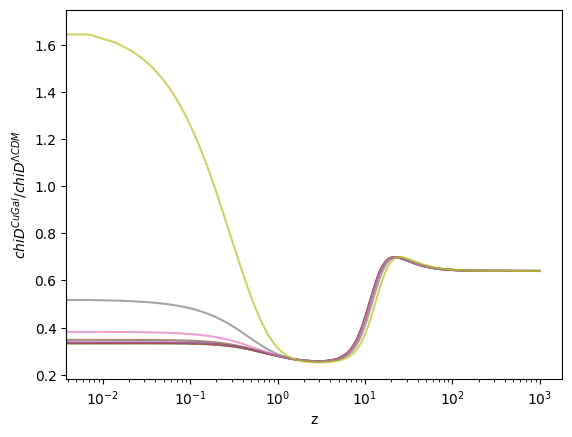

In [73]:
## Plotting ##

fig, axs = plt.subplots(1)


for i in range(len(f_phi_array)):
    force_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files//Output/f_phi_tests/horndeski_model_run_{}_force.txt".format(i))
    a_today = force_today.T[0]
    chiD_today = force_today.T[1]
    coupling = force_today.T[2]

    plt.plot(1/a_today -1, chiD_today, alpha=0.7)


plt.xscale("log")
plt.xlabel("z")
plt.ylabel(r"$chiD^{CuGal}/chiD^{\Lambda CDM}$")


Text(0, 0.5, '$coupling^{CuGal}$')

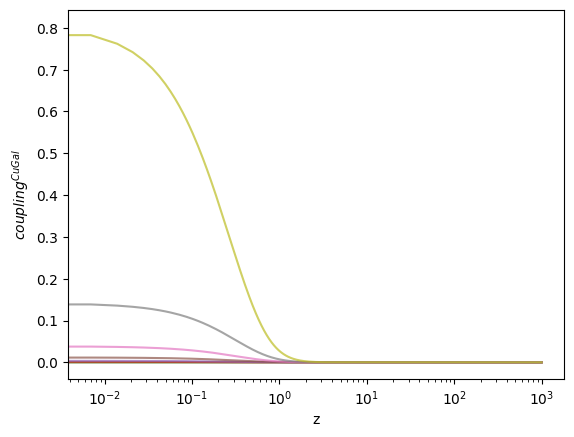

In [44]:
## Plotting ##

fig, axs = plt.subplots(1)


for i in range(len(f_phi_array)):
    force_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files//Output/f_phi_tests/horndeski_model_run_{}_force.txt".format(i))

    a_today = force_today.T[0]
    chiD_today = force_today.T[1]
    coupling = force_today.T[2]

    plt.plot(1/a_today -1, coupling, alpha=0.7)


plt.xscale("log")
plt.xlabel("z")
plt.ylabel(r"$coupling^{CuGal}$")


# Run Frontend

In [14]:
def rewriteluafile(k,fphi,txt,boxsize,n_particles,n_mesh):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi) for all k
    For a certain backend file number (a certain k) it creates a lua file that makes HiCOLA output in a separate folder
    """
    
    # from paper
    wr = 0.0#4.28e-5
    wc = 0.11933
    wb = 0.02242
    h = 0.6766

    wm = wc + wb
    # We assume:
    A_s = 2.1e-9
    n_s = 0.966
    
    # Derived params
    Omg_r = wr/h**2
    Omg_m = (wc+wb)/h**2
    Omg_b = wb/h**2
    
    f_phi = fphi[k]
    k1_tracker = k_1T(Omg_m, Omg_r, f_phi)
    
    Omg_Lambda = (1-f_phi)*(1-Omg_m-Omg_r)
    Omg_DE = (1-Omg_m-Omg_r)
    
    a= open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Hi-COLA_params_emu.lua','r')
    b = a.readlines()
    c = open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles/f_phi_tests/Hi-COLA_params_emu_{}.lua'.format(str(k)),'w')
    for i in range(len(b)):
        if i==19:
            c.write('simulation_name = "my_new_Hi-COLA_simulation_{}"'.format(str(k))+'\n')
        elif i==21:
            c.write('simulation_boxsize = '+str(boxsize)+'\n')
        elif i== 40:
            c.write('cosmology_OmegaCDM = '+str((wm-wb)/h**2)+'\n')
        elif i== 42:
            c.write('cosmology_Omegab = '+str(wb/h**2)+'\n')
        elif i== 46:
            c.write('cosmology_OmegaLambda = '+str(Omg_DE)+'\n')
        elif i== 50:
            c.write('cosmology_TCMB_kelvin = '+str(1e-10)+'\n')
        elif i== 52:
            c.write('cosmology_h = '+str(h)+'\n')
        elif i== 54:
            c.write('cosmology_As = '+str(A_s)+'\n')
        elif i== 56:
            c.write('cosmology_ns = '+str(n_s)+'\n')
        elif i== 63:
            c.write('HiCOLA_expansion_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/f_phi_tests/horndeski_model_run_{}_expansion.txt"'.format(str(k))+'\n')
        elif i== 100:
            c.write('HiCOLA_preforce_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/f_phi_tests/horndeski_model_run_{}_force.txt"'.format(str(k))+'\n')
        elif i== 208:
            c.write('particle_Npart_1D = '+str(n_particles)+'\n')
        elif i== 210:
            c.write('particle_allocation_factor = '+str(2.0)+'\n')
        elif i== 222:
            c.write('output_folder = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_fphi_tests"'+'\n')
        elif i== 229:
            c.write('timestep_nsteps = {20}'+'\n')  
        elif i== 247:
            c.write('ic_random_seed ='+str(108)+'\n')  
        elif i== 269:
            c.write('ic_input_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/P_k_z/Pk_lin_z49_LCDM_backscaled_f_phi_tests.dat"'+'\n')
        elif i== 271:
            c.write('ic_input_redshift = 49.0'+'\n')
        elif i== 312:
            c.write('force_nmesh = '+str(n_mesh)+'\n')
        elif i== 345:
            c.write('pofk_nmesh = '+str(n_mesh)+'\n')
        #elif i== 359:
        #    c.write('pofk_multipole_nmesh = '+str(n_mesh)+'\n')
        #elif i== 375:
        #    c.write('bispectrum_nmesh = '+str(n_mesh)+'\n')
        else:
            c.write(b[i])

    c.close()
    a.close()

# Same as above
txt = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_newdesign_tracker'



In [15]:
"""Re-write lua file"""
for i in range(len(f_phi_array)):
    rewriteluafile(i,f_phi_array,txt,400,512,1536)


In [ ]:
"""Create Pk"""
for i in range(len(f_phi_array)):
    os.system("cd; cd /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/FML/COLASolver; mpirun -np 32 nbody /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles/f_phi_tests/Hi-COLA_params_emu_{}.lua".format(str(i)))

    


#=====================================================
#           ________________  .____         
#           \_   _____/     \ |    |      
#            |    __)/  \ /  \|    |      
#            |     \/    Y    \    |___   
#            \___  /\____|__  /_______ \ 
#                \/         \/        \/ 
#
# Initializing FML, MPI and FFTW
# MPI is enabled. Running with 32 MPI tasks
# OpenMP is enabled. Main task has 40 threads availiable
# MPI + Threads is working
# FFTW is enabled. Thread support is enabled
#
# List of tasks:
# Task    0 [pulsar-cn-3]
#     x-domain [       0 ,  0.03125)
# Task    1 [pulsar-cn-3]
#     x-domain [ 0.03125 ,   0.0625)
# Task    2 [pulsar-cn-3]
#     x-domain [  0.0625 ,  0.09375)
# Task    3 [pulsar-cn-3]
#     x-domain [ 0.09375 ,    0.125)
# Task    4 [pulsar-cn-3]
#     x-domain [   0.125 ,  0.15625)
# Task    5 [pulsar-cn-3]
#     x-domain [ 0.15625 ,   0.1875)
# Task    6 [pulsar-cn-3]
#     x-domain [  0.1875 ,  0.21875)
# Task    7 [pulsa

# Run GR Frontend

In [ ]:
def rewriteluafile(txt,boxsize,n_particles,n_mesh):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi) for all k
    For a certain backend file number (a certain k) it creates a lua file that makes HiCOLA output in a separate folder
    """
    
    # from paper
    wr = 0.0#4.28e-5
    wc = 0.11933
    wb = 0.02242
    h = 0.6766

    wm = wc + wb
    # We assume:
    A_s = 2.1e-9
    n_s = 0.966
    
    # Derived params
    Omg_r = wr/h**2
    Omg_m = (wc+wb)/h**2
    Omg_b = wb/h**2
    
    Omg_DE = (1-Omg_m-Omg_r)
    
    
    a= open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Hi-COLA_params_emu.lua','r')
    b = a.readlines()
    c = open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles/f_phi_tests/Hi-COLA_params_emu_GR.lua','w')
    for i in range(len(b)):
        if i==19:
            c.write('simulation_name = "my_new_Hi-COLA_simulation_GR"'+'\n')
        elif i==21:
            c.write('simulation_boxsize = '+str(boxsize)+'\n')
        elif i==38:
            c.write('cosmology_model = "LCDM"'+'\n')
        elif i== 40:
            c.write('cosmology_OmegaCDM = '+str((wm-wb)/h**2)+'\n')
        elif i== 42:
            c.write('cosmology_Omegab = '+str(wb/h**2)+'\n')
        elif i== 46:
            c.write('cosmology_OmegaLambda = '+str(Omg_DE)+'\n')
        elif i== 50:
            c.write('cosmology_TCMB_kelvin = '+str(1e-10)+'\n')
        elif i== 52:
            c.write('cosmology_h = '+str(h)+'\n')
        elif i== 54:
            c.write('cosmology_As = '+str(A_s)+'\n')
        elif i== 56:
            c.write('cosmology_ns = '+str(n_s)+'\n')
        elif i== 95:
            c.write('gravity_model = "GR"'+'\n')
        elif i== 208:
            c.write('particle_Npart_1D = '+str(n_particles)+'\n')
        elif i== 210:
            c.write('particle_allocation_factor = '+str(2.0)+'\n')
        elif i== 222:
            c.write('output_folder = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_fphi_tests"'+'\n')
        elif i== 229:
            c.write('timestep_nsteps = {20}'+'\n')   
        elif i== 247:
            c.write('ic_random_seed ='+str(108)+'\n') 
        elif i== 269:
            c.write('ic_input_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/P_k_z/Pk_lin_z49_LCDM_backscaled_f_phi_tests.dat"'+'\n')
        elif i== 271:
            c.write('ic_input_redshift = 49.0'+'\n')
        elif i== 312:
            c.write('force_nmesh = '+str(n_mesh)+'\n')
        elif i== 345:
            c.write('pofk_nmesh = '+str(n_mesh)+'\n')
        #elif i== 359:
        #    c.write('pofk_multipole_nmesh = '+str(n_mesh)+'\n')
        #elif i== 375:
        #    c.write('bispectrum_nmesh = '+str(n_mesh)+'\n')
        else:
            c.write(b[i])

    c.close()
    a.close()

# Same as above
txt = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_newdesign_tracker'



In [ ]:
"""Re-write lua file"""
rewriteluafile(txt,400,512,1536)

In [ ]:
"""Create Pk"""
#for i in range(10):
os.system("cd; cd /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/FML/COLASolver; mpirun -np 32 nbody /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles/f_phi_tests/Hi-COLA_params_emu_GR.lua")
    

# Get Plots

Text(0, 0.5, '$P^{CG}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$')

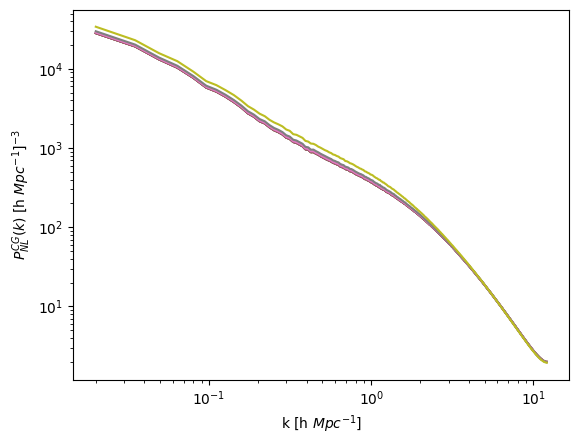

In [20]:
"""Plotting the NL power spectra for the simulations at z = 0"""

for i in range(len(f_phi_array)):
    k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_fphi_tests/pofk_my_new_Hi-COLA_simulation_{}_cb_z0.000.txt".format(i)).T
    
    plt.plot(k,Pk_NL)

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("$P^{CG}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$")

Text(0, 0.5, 'Boost $B(k)$')

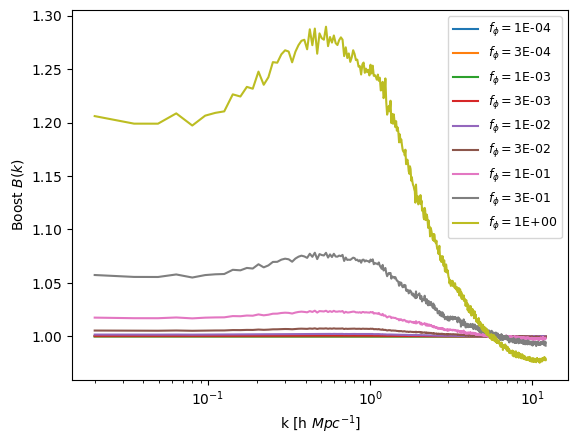

In [21]:
"""Plotting the NL power spectra for the simulations at z = 0"""
params = {'legend.fontsize': 9,
          'legend.handlelength': 2}
plot.rcParams.update(params)

for i in range(len(f_phi_array)):
    k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_fphi_tests/pofk_my_new_Hi-COLA_simulation_{}_cb_z0.000.txt".format(i)).T
    k, Pk_NL_GR,Pk_Lin_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_fphi_tests/pofk_my_new_Hi-COLA_simulation_GR_cb_z0.000.txt".format(i)).T
    
    plt.plot(k,Pk_NL/Pk_NL_GR, label = r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[i]) )

plt.xscale("log")
plt.legend()

plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("Boost $B(k)$")

## Plots to send

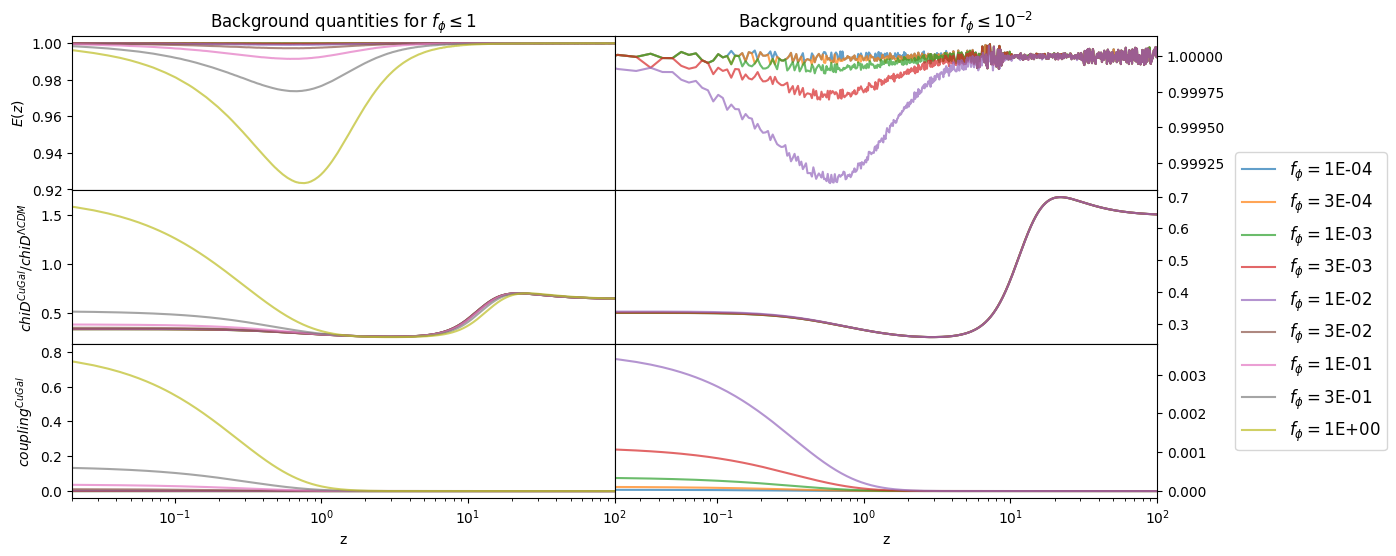

In [22]:
"""Plotting the NL power spectra for the simulations at z = 0"""

fig, ax = plt.subplots(3,2,sharex=True, figsize=(14,6))
fig.subplots_adjust(hspace=0,wspace=0)

params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plot.rcParams.update(params)

for i in range(len(f_phi_array)):
    expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/f_phi_tests/horndeski_model_run_{}_expansion.txt".format(i))

    a_today = expansion_today.T[0]
    E_a_today = expansion_today.T[1]
    E_a_GR = np.sqrt((wb+wc)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wb+wc) -wr))/h
    if (np.min(E_a_today/E_a_GR)) == 0.0:
        zero_vals.append(i)
    ax[0][0].plot(1/a_today -1, E_a_today/E_a_GR, alpha=0.7)

for i in range(len(f_phi_array)):
    force_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files//Output/f_phi_tests/horndeski_model_run_{}_force.txt".format(i))
    a_today = force_today.T[0]
    chiD_today = force_today.T[1]
    coupling = force_today.T[2]

    ax[1][0].plot(1/a_today -1, chiD_today, alpha=0.7)

for i in range(len(f_phi_array)):
    force_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files//Output/f_phi_tests/horndeski_model_run_{}_force.txt".format(i))

    a_today = force_today.T[0]
    chiD_today = force_today.T[1]
    coupling = force_today.T[2]

    ax[2][0].plot(1/a_today -1, coupling, alpha=0.7)



for i in range(len(f_phi_array)-4):
    expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/f_phi_tests/horndeski_model_run_{}_expansion.txt".format(i))

    a_today = expansion_today.T[0]
    E_a_today = expansion_today.T[1]
    E_a_GR = np.sqrt((wb+wc)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wb+wc) -wr))/h
    if (np.min(E_a_today/E_a_GR)) == 0.0:
        zero_vals.append(i)
    ax[0][1].plot(1/a_today -1, E_a_today/E_a_GR, alpha=0.7)

for i in range(len(f_phi_array)-4):
    force_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files//Output/f_phi_tests/horndeski_model_run_{}_force.txt".format(i))
    a_today = force_today.T[0]
    chiD_today = force_today.T[1]
    coupling = force_today.T[2]

    ax[1][1].plot(1/a_today -1, chiD_today, alpha=0.7)

for i in range(len(f_phi_array)-4):
    force_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files//Output/f_phi_tests/horndeski_model_run_{}_force.txt".format(i))

    a_today = force_today.T[0]
    chiD_today = force_today.T[1]
    coupling = force_today.T[2]

    ax[2][1].plot(1/a_today -1, coupling, alpha=0.7)

ax[0][1].yaxis.set_ticks_position("right")
ax[1][1].yaxis.set_ticks_position("right")
ax[2][1].yaxis.set_ticks_position("right")

ax[0][0].set_xscale("log")
ax[1][0].set_xscale("log")
ax[2][0].set_xscale("log")
ax[0][1].set_xscale("log")
ax[1][1].set_xscale("log")
ax[2][1].set_xscale("log")

ax[0][0].set_title("Background quantities for $f_{\phi} \leq 1$")
ax[0][1].set_title("Background quantities for $f_{\phi} \leq 10^{-2}$")
ax[0][0].set_ylabel(r"$E(z)$")
ax[1][0].set_ylabel(r"$chiD^{CuGal}/chiD^{\Lambda CDM}$")
ax[2][0].set_ylabel(r"$coupling^{CuGal}$")

fig.legend([r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[0]),
           r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[1]),
           r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[2]),
           r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[3]),
          r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[4]),
          r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[5]),
          r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[6]),
          r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[7]),
          r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[8])],
          bbox_to_anchor=(1.07, 0.7))
ax[2][0].set_xlim(2e-2,100)

ax[2][0].set_xlabel("z")
ax[2][1].set_xlabel("z")
#plt.savefig("Background_f_phi_rage", bbox_inches='tight')
plt.show()

Text(128.84722222222223, 0.5, 'Boost $B(k)$')

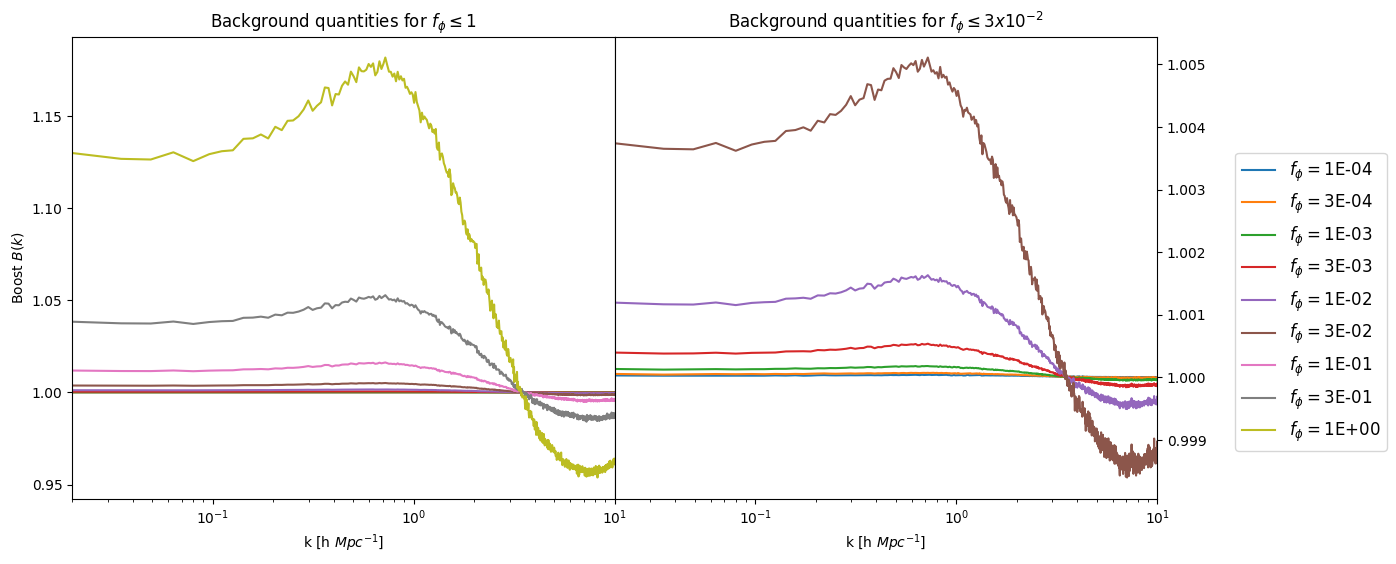

In [36]:
fig, ax = plt.subplots(1,2, figsize=(14,6),sharex=True)
fig.subplots_adjust(hspace=0,wspace=0)

params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plot.rcParams.update(params)

for i in range(len(f_phi_array)):
    k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_fphi_tests/pofk_my_new_Hi-COLA_simulation_{}_cb_z0.522.txt".format(i)).T
    k, Pk_NL_GR,Pk_Lin_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_fphi_tests/pofk_my_new_Hi-COLA_simulation_GR_cb_z0.522.txt".format(i)).T
    
    ax[0].plot(k,Pk_NL/Pk_NL_GR, label = r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[i]) )

for i in range(len(f_phi_array)-3):
    k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_fphi_tests/pofk_my_new_Hi-COLA_simulation_{}_cb_z0.522.txt".format(i)).T
    k, Pk_NL_GR,Pk_Lin_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_fphi_tests/pofk_my_new_Hi-COLA_simulation_GR_cb_z0.522.txt".format(i)).T
    
    ax[1].plot(k,Pk_NL/Pk_NL_GR, label = r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[i]) )


ax[0].set_xscale("log")
ax[1].set_xscale("log")
fig.legend([r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[0]),
           r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[1]),
           r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[2]),
           r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[3]),
          r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[4]),
          r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[5]),
          r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[6]),
          r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[7]),
          r"$f_{\phi} = $" + '%.E' % float('%.1g' % f_phi_array[8])],
          bbox_to_anchor=(1.07, 0.7))

ax[0].set_xlabel(r"k [h $Mpc^{-1}]$")
ax[1].set_xlabel(r"k [h $Mpc^{-1}]$")
ax[1].yaxis.set_ticks_position("right")
ax[0].set_xlim(2e-2,10)
ax[0].set_title("Background quantities for $f_{\phi} \leq 1$")
ax[1].set_title("Background quantities for $f_{\phi} \leq 3 x 10^{-2}$")

plt.savefig("Boosts_f_phi_rage", bbox_inches='tight')
ax[0].set_ylabel("Boost $B(k)$")